In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import seaborn as sns
import plotly.express as px
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Phân tích Xu hướng mua sắm và Ứng dụng Luật Phổ biến trong Gợi ý Sản phẩm cho cửa hàng tạp hóa.
# I. Phân tích bài toán

Dataset được sử dụng là một database các đơn hàng của một cửa hàng tạp hóa điện tử nổi tiếng của Pháp là Hunter cung cấp thế hệ sản phẩm tạp hóa điện tử và phong cách sống mới. Từ nội dung dataset và description đến từ nhà cung cấp (Kaggle), ta có hai công việc chính:
- Phân tích xu hướng mua sắm của khách hàng thông qua dataset
- Gợi ý các sản phẩm cho cửa hàng tạp hóa. 

Nguồn: https://www.kaggle.com/datasets/hunter0007/ecommerce-dataset-for-predictive-marketing-2023/data

Để có thể thực hiện được yêu cầu trên, bài toán được giải quyết thông qua 5 giai đoạn:
- Phân tích bài toán
- Chuẩn bị dữ liệu
- Phân tích hành vi
- Xây dựng mô hình gợi ý sản phẩm
- Triển khai

# II. Chuẩn bị dữ liệu
### Lấy dữ liệu và thông tin của dataset

In [149]:
# https://www.kaggle.com/datasets/hunter0007/ecommerce-dataset-for-predictive-marketing-2023/data
eCommerce_df = pd.read_csv('./dataset/ECommerce_consumer_behaviour.csv')
df = eCommerce_df.copy()

Dataset bao gồm 2019501 dòng tương với 12 thuộc tính:

- order_id: Một số phân biệt dùng để xác định đơn hàng cụ thể.
- user_id: Một số phân biệt dùng để xác định người dùng cụ thể.
- order_number: Số thứ tự của đơn hàng trong lịch sử đặt hàng của người dùng.
- order_dow: Ngày trong tuần mà đơn hàng được thực hiện (ví dụ: Thứ Hai, Thứ Ba, vv).
- order_hour_of_day: Giờ trong ngày mà đơn hàng được thực hiện.
- days_since_prior_order: Số ngày kể từ đơn hàng trước đó của người dùng.
- product_id: Một số phân biệt để xác định sản phẩm cụ thể.
- add_to_cart_order: Số lượng sản phẩm được thêm vào giỏ hàng trong đơn hàng.
- reordered: Chỉ số cho biết liệu sản phẩm đã được đặt hàng lại trong đơn hàng hiện tại hay không (có hoặc không có).
- department_id: Số phân biệt được cấp cho từng bộ phận (department) khác nhau trong cửa hàng.
- department: Tên của bộ phận (department) tương ứng với sản phẩm.
- product_name: Tên của sản phẩm cụ thể.

In [150]:
df

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name
0,2425083,49125,1,2,18,NaN,17,1,0,13,pantry,baking ingredients
1,2425083,49125,1,2,18,NaN,91,2,0,16,dairy eggs,soy lactosefree
2,2425083,49125,1,2,18,NaN,36,3,0,16,dairy eggs,butter
3,2425083,49125,1,2,18,NaN,83,4,0,4,produce,fresh vegetables
4,2425083,49125,1,2,18,NaN,83,5,0,4,produce,fresh vegetables
...,...,...,...,...,...,...,...,...,...,...,...,...
2019496,3390742,199430,16,3,18,5.0,83,8,0,4,produce,fresh vegetables
2019497,458285,128787,42,2,19,3.0,115,1,1,7,beverages,water seltzer sparkling water
2019498,458285,128787,42,2,19,3.0,32,2,1,4,produce,packaged produce
2019499,458285,128787,42,2,19,3.0,32,3,1,4,produce,packaged produce


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019501 entries, 0 to 2019500
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_number            int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_id              int64  
 7   add_to_cart_order       int64  
 8   reordered               int64  
 9   department_id           int64  
 10  department              object 
 11  product_name            object 
dtypes: float64(1), int64(9), object(2)
memory usage: 184.9+ MB


### Thống kê tóm tắt

In [152]:
df.isnull().sum()

order_id                  0     
user_id                   0     
order_number              0     
order_dow                 0     
order_hour_of_day         0     
days_since_prior_order    124342
product_id                0     
add_to_cart_order         0     
reordered                 0     
department_id             0     
department                0     
product_name              0     
dtype: int64

In [153]:
null_count = df['days_since_prior_order'].isnull().sum()
total_rows = len(df)

percentage_null = (null_count / total_rows) * 100

print(f"Số lượng giá trị null trong cột 'days_since_prior_order': {null_count}")
print(f"Phần trăm giá trị null trong cột 'days_since_prior_order': {percentage_null:.2f}%")
print(f"Các giá trị có trong cột 'days_since_prior_order': {df['days_since_prior_order'].unique()}")


Số lượng giá trị null trong cột 'days_since_prior_order': 124342
Phần trăm giá trị null trong cột 'days_since_prior_order': 6.16%
Các giá trị có trong cột 'days_since_prior_order': [nan  3.  6.  7. 30. 20.  4.  8. 15. 10. 28.  9. 12. 11.  2. 25. 13. 29.
 14. 21.  5.  1. 18.  0. 19. 17. 22. 26. 24. 16. 23. 27.]


Từ kết quả trên ta có các nhận xét sau về dataset:
- order_id, user_id, order_number, order_dow, order_hour_of_day, product_id, add_to_cart_order, reordered, department_id, department, product_name: Tất cả các cột này không có giá trị null, tức là không có dữ liệu thiếu trong các cột này.
- days_since_prior_order: Có 124,342 giá trị null trong cột này. Điều này có thể ám chỉ rằng có một số đơn hàng đầu tiên trong lịch sử không có giá trị "days_since_prior_order" và chiếm 6.16%. Để có thể tiếp tục làm việc với dataset ta cần xử lý các giá trị null này

In [154]:
for col in df.columns:
    if df[col].dtypes == 'float64':
        df[col].fillna(-1,inplace=True) 

df['days_since_prior_order']= df['days_since_prior_order'].astype(np.int64)

In [155]:
df.isnull().sum()

order_id                  0
user_id                   0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
department_id             0
department                0
product_name              0
dtype: int64

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019501 entries, 0 to 2019500
Data columns (total 12 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   order_id                int64 
 1   user_id                 int64 
 2   order_number            int64 
 3   order_dow               int64 
 4   order_hour_of_day       int64 
 5   days_since_prior_order  int64 
 6   product_id              int64 
 7   add_to_cart_order       int64 
 8   reordered               int64 
 9   department_id           int64 
 10  department              object
 11  product_name            object
dtypes: int64(10), object(2)
memory usage: 184.9+ MB


Từ đoạn code trên, ta dùng fillna - một phương thức của pandas để điền vào các ô trống hoặc null trong Dataframe bằng giá trị -1. Nghĩa là các ô này không có giá trị. Sau đó, ta chuyển đổi dữ liệu từ số thực (float) thành số tự nhiên (int) để dễ thao tác và xử lý trên toàn bộ dataset.

# III. Phân tích hành vi
### Trực quan hóa dữ liệu

In [157]:
for colum in df:
    unique_values = np.unique(df[colum])
    nr_values = len(unique_values)
    if nr_values < 50:
        print("Số giá trị phân biệt của trường {} : {} --- {}".format(colum, nr_values, unique_values))
    else:
         print("Số giá trị phân biệt của trường {} : {}".format(colum, nr_values))

Số giá trị phân biệt của trường order_id : 200000
Số giá trị phân biệt của trường user_id : 105273
Số giá trị phân biệt của trường order_number : 100
Số giá trị phân biệt của trường order_dow : 7 --- [0 1 2 3 4 5 6]
Số giá trị phân biệt của trường order_hour_of_day : 24 --- [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Số giá trị phân biệt của trường days_since_prior_order : 32 --- [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30]
Số giá trị phân biệt của trường product_id : 134
Số giá trị phân biệt của trường add_to_cart_order : 137
Số giá trị phân biệt của trường reordered : 2 --- [0 1]
Số giá trị phân biệt của trường department_id : 21 --- [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Số giá trị phân biệt của trường department : 21 --- ['alcohol' 'babies' 'bakery' 'beverages' 'breakfast' 'bulk' 'canned goods'
 'dairy eggs' 'deli' 'dry goods pasta' 'frozen' 'household'
 'international' 'me

### Phân tích hành vi mua hàng dự trên số lượng sản phẩm được thêm vào giỏ hàng

In [158]:
grouped = df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
print(grouped)
grouped = grouped.add_to_cart_order.value_counts()
print(f"Số lượng giá trị riêng biệt của số lượng hàng được thêm vào giỏ hàng {len(grouped)}")
print(grouped)

        order_id  add_to_cart_order
0       10        15               
1       11        5                
2       28        16               
3       38        9                
4       56        10               
...     ..        ..               
199995  3420991   13               
199996  3421019   3                
199997  3421027   12               
199998  3421074   4                
199999  3421080   9                

[200000 rows x 2 columns]
Số lượng giá trị riêng biệt của số lượng hàng được thêm vào giỏ hàng 82
5      14242
6      14146
4      13760
7      13695
8      12741
       ...  
95     1    
83     1    
137    1    
100    1    
87     1    
Name: add_to_cart_order, Length: 82, dtype: int64


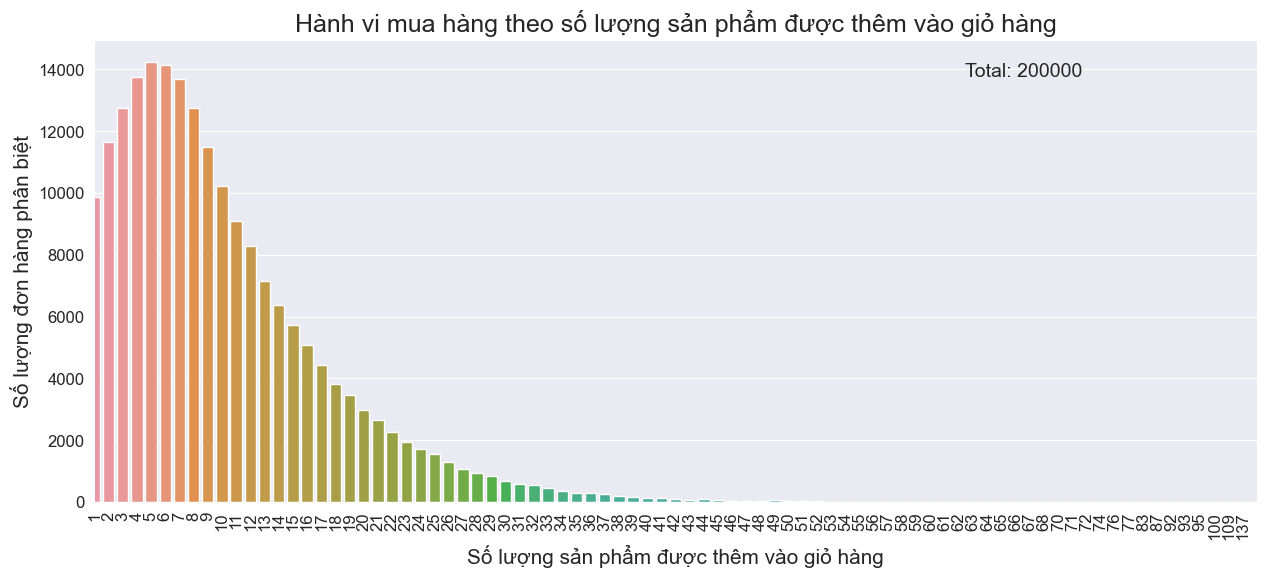

In [159]:
total = sum(value for index, value in grouped.items())

sns.set_style('dark')
sns.set_palette("rocket_r")
f, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=grouped.index, y=grouped.values, ax=ax)
ax.grid(True, axis='y')
plt.xticks(rotation='vertical', fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Số lượng đơn hàng phân biệt', fontsize=15)
plt.xlabel('Số lượng sản phẩm được thêm vào giỏ hàng', fontsize=15)
plt.title('Hành vi mua hàng theo số lượng sản phẩm được thêm vào giỏ hàng', fontsize=18)
plt.xlim(0, 82)
plt.text(0.85, 0.95, f'Total: {total}', transform=ax.transAxes, fontsize=14, ha='right', va='top')

plt.show()

Từ biểu đồ trên, ta thấy người dùng có xu hướng:
- Mua từ 1 đến 10 sản phẩm, trong đó cao nhất là từ 2 - 8 (hơn 12000 đơn hàng tương đương với 6% ~ 7%).
- Từ 11 đến 16 sản phẩm giảm mạnh và không chiếm nhiều trên tổng số lượng đơn hàng, từ dưới 4000 đến 8000 đơn hàng (chiếm 2% ~ 4%)
- Từ 16 trở lên chiếm phần trăm ít hơn (<2%)

### Phân tích hành vi mua hàng dự trên thời gian đơn hàng được thực hiện trong ngày

In [160]:
grouped = df.groupby("order_id")["order_hour_of_day"].aggregate("max").reset_index()
print(grouped)
grouped = grouped.order_hour_of_day.value_counts()
print(f"Số lượng giá trị riêng biệt của số lượng hàng được thêm vào giỏ hàng {len(grouped)}")
print(grouped)

        order_id  order_hour_of_day
0       10        8                
1       11        19               
2       28        13               
3       38        16               
4       56        12               
...     ..        ..               
199995  3420991   9                
199996  3421019   10               
199997  3421027   20               
199998  3421074   8                
199999  3421080   11               

[200000 rows x 2 columns]
Số lượng giá trị riêng biệt của số lượng hàng được thêm vào giỏ hàng 24
10    17102
11    16748
15    16649
14    16600
13    16189
12    15942
16    15928
9     14989
17    13201
18    10716
8     10294
19    8164 
20    6209 
7     5310 
21    4492 
22    3731 
23    2302 
6     1803 
0     1311 
1     719  
5     555  
2     429  
4     330  
3     287  
Name: order_hour_of_day, dtype: int64


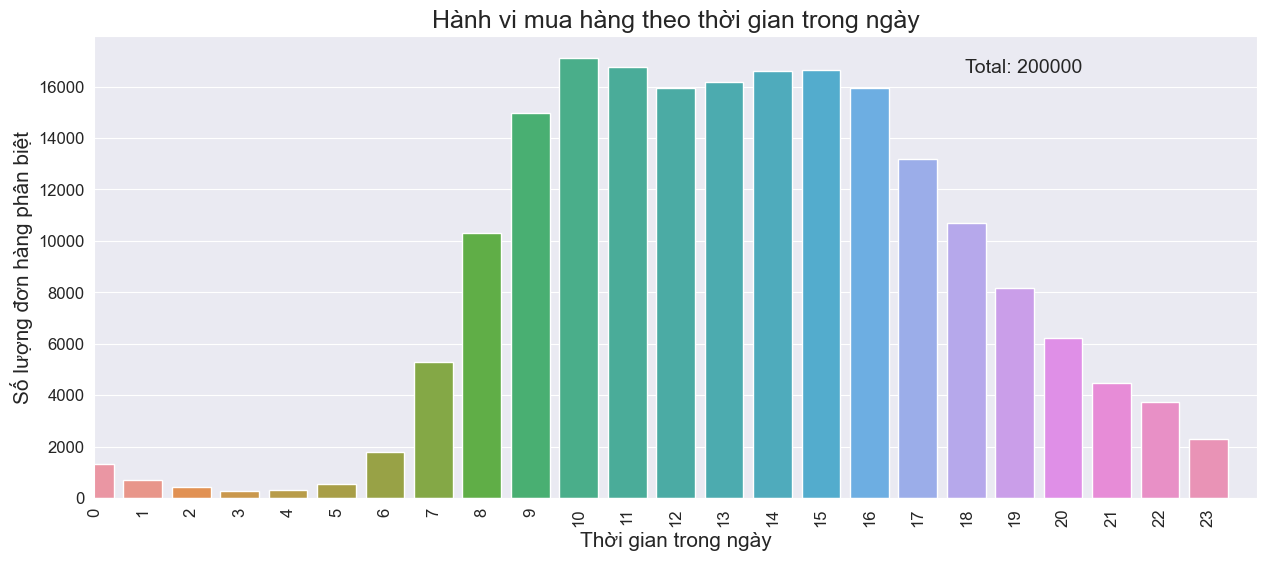

In [161]:
total = sum(value for index, value in grouped.items())

sns.set_style('dark')
sns.set_palette("rocket_r")
f, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=grouped.index, y=grouped.values, ax=ax)
ax.grid(True, axis='y')
plt.xticks(rotation='vertical', fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Số lượng đơn hàng phân biệt', fontsize=15)
plt.xlabel('Thời gian trong ngày', fontsize=15)
plt.title('Hành vi mua hàng theo thời gian trong ngày', fontsize=18)
plt.xlim(0, 24)
plt.text(0.85, 0.95, f'Total: {total}', transform=ax.transAxes, fontsize=14, ha='right', va='top')

plt.show()

Từ biểu đồ trên ta thấy người dùng có xu hướng:
- Mua đồ vào thời gian từ 10h ~ 16h
- Có 1 số lượng người mua hàng từ 7h - 9h
- Vẫn có xu hướng mua hàng sau 16h dù không nhiều
- Chỉ có một số lượng thiểu số người dùng mua hàng vào 0h đến 5h

--> Xu hướng mua hàng vào sáng và trưa, ít người mua hàng vào tối hay khuya

### Phân tích hành vi mua hàng dự trên ngày và giờ mua hàng

In [162]:
day_hour_df = df.groupby(["order_dow", "order_hour_of_day"])["order_id"].nunique().reset_index()
total_order_id = day_hour_df["order_id"].sum()

print(day_hour_df, total_order_id)

day_hour_df_piv = day_hour_df.pivot('order_dow', 'order_hour_of_day', 'order_id')/total_order_id
total_piv = day_hour_df_piv.values.sum()

print(day_hour_df_piv, total_piv)

     order_dow  order_hour_of_day  order_id
0    0          0                  230     
1    0          1                  153     
2    0          2                  92      
3    0          3                  44      
4    0          4                  46      
..  ..         ..                  ..      
163  6          19                 1062    
164  6          20                 784     
165  6          21                 608     
166  6          22                 506     
167  6          23                 351     

[168 rows x 3 columns] 200000
order_hour_of_day         0         1         2         3         4         5  \
order_dow                                                                       
0                  0.001150  0.000765  0.000460  0.000220  0.000230  0.000355   
1                  0.001010  0.000525  0.000285  0.000225  0.000265  0.000405   
2                  0.000885  0.000410  0.000255  0.000220  0.000250  0.000455   
3                  0.000820  0.00041

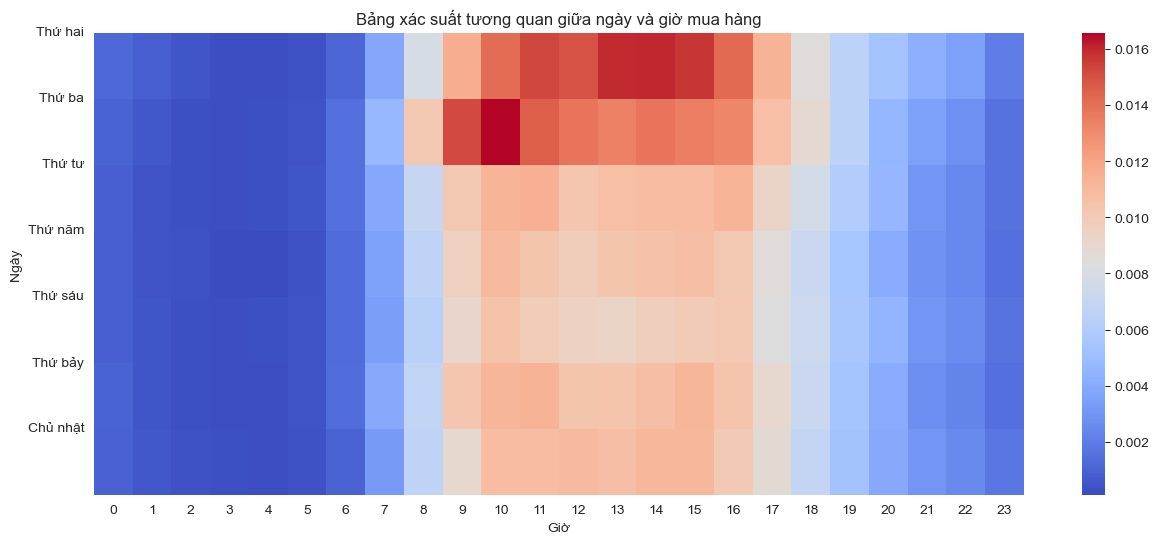

In [163]:
plt.figure(figsize=(15,6))
sns.heatmap(day_hour_df_piv, cmap='coolwarm')
plt.yticks([0,1, 2, 3, 4, 5, 6],["Thứ hai", "Thứ ba", "Thứ tư", "Thứ năm", "Thứ sáu", "Thứ bảy", "Chủ nhật"])
plt.xlabel("Giờ")
plt.yticks(rotation=0)
plt.ylabel("Ngày")
plt.title("Bảng xác suất tương quan giữa ngày và giờ mua hàng")

plt.show()

Từ bảng biểu đồ nhiệt độ trên ta có các nhận xét sau:
- Tương tự như phân tích hành vi trên dựa trên thười gian thực hiện đơn trong 1 ngày thì số lượng đơn hàng được thực hiện nhiều nhất từ 10h đến 16h
- Người dùng có xu hướng mua hàng nhiều hơn vào đầu tuần (thứ 2 và thứ 3), còn các ngày còn lại có xu hướng giảm nhiều (như trên biểu đồ là từ 1.6% còn tầm 1.2%)

### Trực quan hóa 10 sản phẩm bán nhiều nhất và 10 sản phẩm bán ít nhất

In [164]:
top_products = df.groupby('product_name')['order_id'].count().sort_values(ascending=False).head(10)

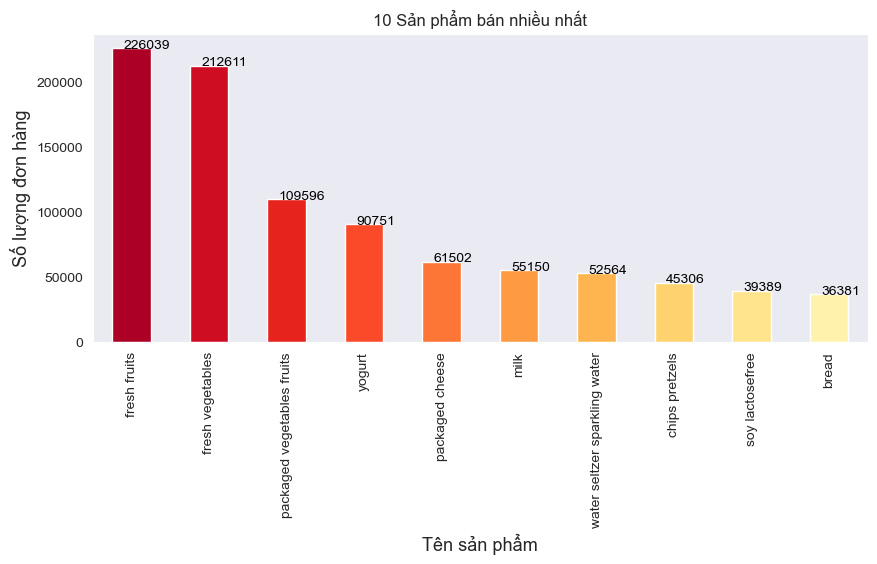

In [165]:
colors = sns.color_palette("YlOrRd_r", len(top_products))

ax = top_products.plot(kind='bar', title='10 Sản phẩm bán nhiều nhất', figsize=(10, 4), color=colors)
plt.xlabel('Tên sản phẩm',fontsize=13)
plt.ylabel('Số lượng đơn hàng',fontsize=13)
for i in ax.patches:
    ax.text(i.get_x()+0.15, i.get_height()+50, str(round(i.get_height())), fontsize=10, color='black')
plt.show()

In [166]:
bottom_products = df.groupby('product_name')['order_id'].count().sort_values(ascending=False).tail(10)

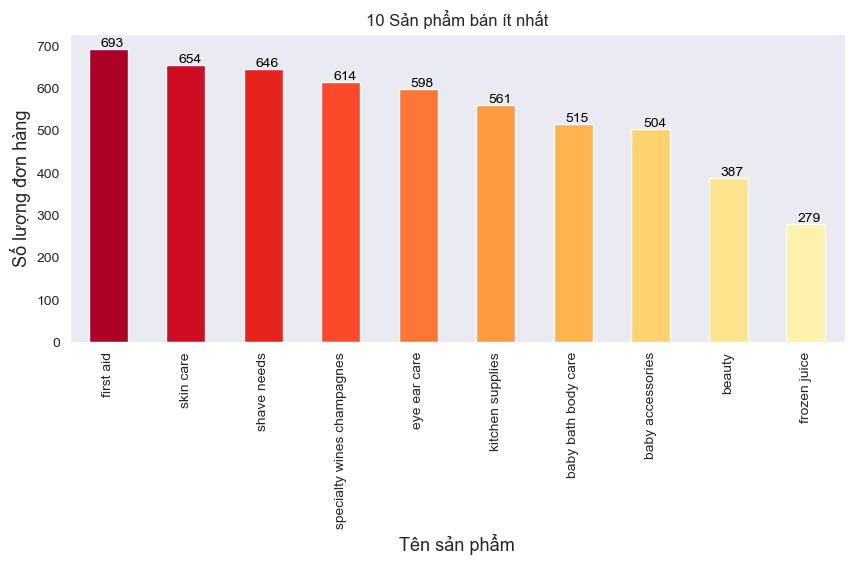

In [167]:
colors = sns.color_palette("YlOrRd_r", len(bottom_products))

ax = bottom_products.plot(kind='bar', title='10 Sản phẩm bán ít nhất', figsize=(10, 4), color=colors)
plt.xlabel('Tên sản phẩm',fontsize=13)
plt.ylabel('Số lượng đơn hàng',fontsize=13)
for i in ax.patches:
    ax.text(i.get_x()+0.15, i.get_height()+5, str(round(i.get_height())), fontsize=10, color='black')
plt.show()

In [168]:
grouped = df.groupby(["department"])["reordered"].aggregate('count').reset_index()
total_reordered = grouped['reordered'].sum()
grouped['reorder_ratio'] = grouped['reordered'] / total_reordered * 100
grouped = grouped.sort_values(by='reordered', ascending=False)[:15].reset_index()
del grouped["index"]
grouped

,department,reordered,reorder_ratio
0,produce,588996,29.165423
1,dairy eggs,336915,16.683082
2,snacks,180692,8.947359
3,beverages,168126,8.325126
4,frozen,139536,6.909430
5,pantry,116262,5.756967
6,bakery,72983,3.613913
7,canned goods,66053,3.270758
8,deli,65176,3.227332
9,dry goods pasta,54054,2.676602


Từ bảng trên, chúng ta có thể thấy rõ rằng nông sản (produce), sản phẩm từ trứng (dairy eggs), đồ ăn nhẹ (snack) và đồ uống (beverages) là những danh mục hàng đầu được khách hàng quan tâm mua hàng nhất với tỷ lệ mua lại cao.

# IV. Xây dựng mô hình gợi ý sản phẩm

### Thuật toán Apriori

**Thuật toán Apriori** là một thuật toán phổ biến được sử dụng trong khai thác dữ liệu để tìm các tập phổ biến trong tập dữ liệu. Nó hoạt động bằng cách quét tập dữ liệu để xác định các mục thường xuất hiện, sau đó sử dụng thông tin này để tạo ra các quy tắc về những mục nào có xu hướng xuất hiện cùng nhau.

Tính chất Apriori: Nếu một tập mục là phổ biến thị mọi tập mục con của nó cũng phổ biến

Trong đó mô hình gồm 2 bước chính:
1. Bước đầu tiên liên quan đến việc xác định tất cả các tập mục đáp ứng ngưỡng hỗ trợ tối thiểu được chỉ định (nghĩa là số lần xuất hiện tối thiểu cần thiết để một tập mục được coi là thường xuyên). Đây được gọi là bước "tạo tập mục thường xuyên".
2. Bước thứ hai liên quan đến việc sử dụng các tập phổ biến được tạo ở bước một để tạo quy tắc kết hợp, là các quy tắc mô tả mối quan hệ giữa các mục khác nhau trong tập dữ liệu. Những quy tắc này có thể được sử dụng để dự đoán những mặt hàng nào có khả năng được mua cùng nhau hoặc để xác định những mặt hàng nào thường được liên kết với nhau.

Thuật toán Apriori được sử dụng rộng rãi trong các ngành bán lẻ và thương mại điện tử để phân tích giỏ hàng thị trường, bao gồm việc phân tích các kiểu mua hàng của khách hàng để xác định những mặt hàng nào thường được mua cùng nhau.

In [169]:
pd.set_option('display.max_colwidth', -1)

C:\Users\iFx\AppData\Local\Temp\ipykernel_13600\3652881321.py:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [170]:
df

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name
0,2425083,49125,1,2,18,-1,17,1,0,13,pantry,baking ingredients
1,2425083,49125,1,2,18,-1,91,2,0,16,dairy eggs,soy lactosefree
2,2425083,49125,1,2,18,-1,36,3,0,16,dairy eggs,butter
3,2425083,49125,1,2,18,-1,83,4,0,4,produce,fresh vegetables
4,2425083,49125,1,2,18,-1,83,5,0,4,produce,fresh vegetables
...,...,...,...,...,...,...,...,...,...,...,...,...
2019496,3390742,199430,16,3,18,5,83,8,0,4,produce,fresh vegetables
2019497,458285,128787,42,2,19,3,115,1,1,7,beverages,water seltzer sparkling water
2019498,458285,128787,42,2,19,3,32,2,1,4,produce,packaged produce
2019499,458285,128787,42,2,19,3,32,3,1,4,produce,packaged produce


In [171]:
def bar_plot(df,col):
    fig = px.bar(
        df,
        x = df[col].value_counts().keys(), 
        y = df[col].value_counts().values,
        color= df[col].value_counts().keys()
    )
    fig.update_layout(
        xaxis_title= col,
        yaxis_title="Count",
    )
    
    fig.show()

In [172]:
bar_plot(df, 'product_name')

c:\Users\iFx\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\iFx\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Từ biểu đồ trên ta dễ dàng nhận ra:
- So sánh tương quan giữa các sản phẩm
- Xu hướng mua sắm các sản phẩm
- Mọi người có xu hướng mua 4 sản phẩm: fresh fruits, fresh vegetables, packed vegetables fruits, yogurt khi ở biểu đồ 4 cột tương ứng cao hẳn so với các cột còn lại

Tiếp đến ta chuẩn bị dữ liệu để sử dụng thuật toán Apriori để khai phá luật kết hợp. Trong đó, dữ liệu được chuẩn bị theo hai hướng để so sánh:
- Gom các sản phẩm theo dự trên từng đơn hàng và gian hàng
- Gom các sản phẩm dự trên người mua và gian hàng

In [173]:
new_df = df.groupby(['order_id','department'])['product_name'].apply(sum)
new_df

order_id  department  
10        babies          baby food formulababy food formula                                                                                                        
          canned goods    canned meals beans                                                                                                                        
          dairy eggs      cream                                                                                                                                     
          meat seafood    meat counter                                                                                                                              
          produce         fresh fruitsfresh vegetablesfresh herbsfresh fruitsfresh vegetablesfresh herbsfresh fruitsfresh vegetablesfresh vegetablesfresh vegetables
                                                                                             ...                                                        

In [174]:
new_user_df = df.groupby(['user_id','department'])['product_name'].apply(sum)
new_user_df

user_id  department
2        dairy eggs    packaged cheesepackaged cheese                                
         deli          lunch meatprepared soups saladsfresh dips tapenades           
         produce       fresh fruitsfresh fruitsfresh fruits                          
         snacks        popcorn jerkycrackerschips pretzels                           
3        beverages     water seltzer sparkling water                                 
                                   ...                                               
206209   frozen        frozen produce                                                
         household     laundrytrash bags linersfood storagedish detergents           
         pantry        spices seasonings                                             
         produce       packaged vegetables fruitsfresh fruitsfresh fruitsfresh fruits
         snacks        crackerscrackers                                              
Name: product_name, Length: 639006

In [175]:
transactions = [a[1]['product_name'].tolist() for a in list(df.groupby(['order_id','department']))]
transactions_user = [a[1]['product_name'].tolist() for a in list(df.groupby(['user_id','department']))]

In [176]:
first_20_transactions = transactions[:20]
first_20_transactions_user = transactions_user[:20]

In [177]:
for i, transaction in enumerate(first_20_transactions):
    print(f"Transaction {i+1}: {transaction}")

Transaction 1: ['baby food formula', 'baby food formula']
Transaction 2: ['canned meals beans']
Transaction 3: ['cream']
Transaction 4: ['meat counter']
Transaction 5: ['fresh fruits', 'fresh vegetables', 'fresh herbs', 'fresh fruits', 'fresh vegetables', 'fresh herbs', 'fresh fruits', 'fresh vegetables', 'fresh vegetables', 'fresh vegetables']
Transaction 6: ['canned meals beans']
Transaction 7: ['fresh dips tapenades']
Transaction 8: ['frozen meals']
Transaction 9: ['oils vinegars']
Transaction 10: ['chips pretzels']
Transaction 11: ['butter', 'other creams cheeses', 'milk', 'packaged cheese', 'milk', 'cream', 'milk', 'yogurt']
Transaction 12: ['poultry counter']
Transaction 13: ['spreads']
Transaction 14: ['fresh fruits', 'fresh fruits', 'fresh vegetables', 'fresh fruits', 'fresh vegetables', 'fresh fruits']
Transaction 15: ['frozen produce']
Transaction 16: ['oils vinegars']
Transaction 17: ['packaged vegetables fruits', 'packaged vegetables fruits', 'fresh vegetables', 'fresh herb

In [178]:
print("\n User")

for i, transaction in enumerate(first_20_transactions_user):
    print(f"Transaction {i+1}: {transaction}")


 User
Transaction 1: ['packaged cheese', 'packaged cheese']
Transaction 2: ['lunch meat', 'prepared soups salads', 'fresh dips tapenades']
Transaction 3: ['fresh fruits', 'fresh fruits', 'fresh fruits']
Transaction 4: ['popcorn jerky', 'crackers', 'chips pretzels']
Transaction 5: ['water seltzer sparkling water']
Transaction 6: ['other creams cheeses', 'packaged cheese', 'soy lactosefree', 'soy lactosefree', 'soy lactosefree']
Transaction 7: ['ice cream ice', 'frozen breakfast']
Transaction 8: ['paper goods']
Transaction 9: ['spreads']
Transaction 10: ['fresh fruits', 'packaged vegetables fruits', 'fresh fruits', 'fresh fruits', 'packaged vegetables fruits', 'packaged vegetables fruits']
Transaction 11: ['nuts seeds dried fruit', 'nuts seeds dried fruit', 'crackers']
Transaction 12: ['bread']
Transaction 13: ['refrigerated', 'coffee', 'refrigerated', 'refrigerated', 'refrigerated', 'coffee', 'refrigerated']
Transaction 14: ['canned meals beans', 'canned fruit applesauce']
Transaction 

In [179]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
te_ary

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [180]:
te_user = TransactionEncoder()
te_ary_user = te_user.fit(transactions_user).transform(transactions_user)
te_ary_user

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [181]:
head_cols = [{'Product': ''.join(col)} for col in te.columns_[:20]]

# Create a DataFrame from the list of dictionaries
df_order = pd.DataFrame(head_cols)

# Display the DataFrame
print(df_order)

                         Product
0   air fresheners candles      
1   asian foods                 
2   baby accessories            
3   baby bath body care         
4   baby food formula           
5   bakery desserts             
6   baking ingredients          
7   baking supplies decor       
8   beauty                      
9   beers coolers               
10  body lotions soap           
11  bread                       
12  breakfast bakery            
13  breakfast bars pastries     
14  bulk dried fruits vegetables
15  bulk grains rice dried goods
16  buns rolls                  
17  butter                      
18  candy chocolate             
19  canned fruit applesauce     


In [182]:
head_cols_user = [{'Product': ''.join(col)} for col in te_user.columns_[:20]]

# Create a DataFrame from the list of dictionaries
df_user= pd.DataFrame(head_cols_user)

# Display the DataFrame
print(df_user)

                         Product
0   air fresheners candles      
1   asian foods                 
2   baby accessories            
3   baby bath body care         
4   baby food formula           
5   bakery desserts             
6   baking ingredients          
7   baking supplies decor       
8   beauty                      
9   beers coolers               
10  body lotions soap           
11  bread                       
12  breakfast bakery            
13  breakfast bars pastries     
14  bulk dried fruits vegetables
15  bulk grains rice dried goods
16  buns rolls                  
17  butter                      
18  candy chocolate             
19  canned fruit applesauce     


In [183]:
transactions = pd.DataFrame(te_ary, columns=te.columns_)
pf = transactions.describe()
pf

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
count,947720,947720,947720,947720,947720,947720,947720,947720,947720,947720,...,947720,947720,947720,947720,947720,947720,947720,947720,947720,947720
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,946687,939054,947222,947244,938649,945628,932393,946430,947366,945863,...,932083,936318,941148,936429,945561,945800,945149,909119,946188,894985


In [184]:
transactions_user = pd.DataFrame(te_ary_user, columns=te_user.columns_)
pf_user = transactions_user.describe()
pf_user

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
count,639006,639006,639006,639006,639006,639006,639006,639006,639006,639006,...,639006,639006,639006,639006,639006,639006,639006,639006,639006,639006
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,638062,631396,638572,638554,632592,637201,625861,637761,638660,637531,...,625783,629963,633844,629603,637236,637208,636663,612103,637855,603025


In [185]:
f = pf.iloc[0]-pf.iloc[3]
a = f.tolist()
b = list(f.index)
item = pd.DataFrame([[a[r],b[r]]for r in range(len(a))], columns=['Count','Item'])
item = item.sort_values(['Count'], ascending=False)
# item = item.sort_values(['Count'], ascending=False).head(50)
item.head(10)

,Count,Item
50,111199,fresh fruits
53,88872,fresh vegetables
98,73083,packaged vegetables fruits
133,52735,yogurt
83,48665,milk
93,46199,packaged cheese
131,38601,water seltzer sparkling water
25,33887,chips pretzels
119,33671,soy lactosefree
11,32773,bread


In [186]:
f_user = pf_user.iloc[0]-pf_user.iloc[3]
a_user = f_user.tolist()
b_user = list(f_user.index)
item_user = pd.DataFrame([[a_user[r],b_user[r]]for r in range(len(a_user))], columns=['Count','Item'])
item_user = item_user.sort_values(['Count'], ascending=False)
# item_user = item_user.sort_values(['Count'], ascending=False).head(50)
item_user

,Count,Item
50,66823,fresh fruits
53,56265,fresh vegetables
98,49230,packaged vegetables fruits
133,35981,yogurt
93,34049,packaged cheese
...,...,...
121,477,specialty wines champagnes
3,452,baby bath body care
2,434,baby accessories
8,346,beauty


In [187]:
pio.renderers.default = "notebook_connected"
# TREEMAP VISUALIZATION OF ITEMS
fig = px.treemap(item, path=['Item'], values='Count')
fig.update_layout(title='Visualizing Item Counts with a Treemap', title_font_size=20, title_x=0.5)
fig.show()

c:\Users\iFx\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\iFx\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [188]:
pio.renderers.default = "notebook_connected"
# TREEMAP VISUALIZATION OF ITEMS
fig = px.treemap(item_user, path=['Item'], values='Count')
fig.update_layout(title='Visualizing Item Counts with a Treemap', title_font_size=20, title_x=0.5)
fig.show()

c:\Users\iFx\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\Users\iFx\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [217]:
# Tính trung bình (mean) của cột 'Count'
mean_value = item['Count'].mean()

# Tính trung vị (median) của cột 'Count'
median_value = item['Count'].median()

count_column = item['Count'].sum()

print(mean_value, median_value, count_column)
print(mean_value/count_column)
print(median_value/count_column)

min_support = mean_value/count_column

# For User
# Tính trung bình (mean) của cột 'Count'
mean_value_user = item_user['Count'].mean()

# Tính trung vị (median) của cột 'Count'
median_value_user = item_user['Count'].median()

count_column_user = item_user['Count'].sum()

print(mean_value_user, median_value_user, count_column_user)
print(mean_value_user/count_column_user)
print(median_value_user/count_column_user)

min_support_user = mean_value_user/count_column_user

10844.149253731342 5360.5 1453116
0.007462686567164179
0.0036889690843676624
8280.358208955224 4503.0 1109568
0.007462686567164179
0.00405833621733864


In [218]:
freq_items = apriori(transactions, min_support=min_support, use_colnames=True, verbose=1)
freq_items.head(7)

Processing 28 combinations | Sampling itemset size 432


,support,itemsets
0,0.009144,(asian foods)
1,0.009571,(baby food formula)
2,0.016172,(baking ingredients)
3,0.034581,(bread)
4,0.014301,(breakfast bakery)
5,0.015686,(butter)
6,0.014626,(candy chocolate)


In [219]:
freq_items['length'] = freq_items['itemsets'].apply(lambda x: len(x))
freq_items.head(10)

,support,itemsets,length
0,0.009144,(asian foods),1
1,0.009571,(baby food formula),1
2,0.016172,(baking ingredients),1
3,0.034581,(bread),1
4,0.014301,(breakfast bakery),1
5,0.015686,(butter),1
6,0.014626,(candy chocolate),1
7,0.015171,(canned jarred vegetables),1
8,0.014710,(canned meals beans),1
9,0.019533,(cereal),1


In [220]:
freq_items.tail(10)

,support,itemsets,length
72,0.007682,"(other creams cheeses, packaged cheese)",2
73,0.009763,"(soy lactosefree, packaged cheese)",2
74,0.018681,"(yogurt, packaged cheese)",2
75,0.012281,"(soy lactosefree, yogurt)",2
76,0.013045,"(fresh vegetables, fresh fruits, fresh herbs)",3
77,0.009178,"(packaged vegetables fruits, fresh fruits, fresh herbs)",3
78,0.039374,"(fresh vegetables, packaged vegetables fruits, fresh fruits)",3
79,0.009914,"(fresh vegetables, packaged vegetables fruits, fresh herbs)",3
80,0.008117,"(packaged cheese, yogurt, milk)",3
81,0.008370,"(fresh vegetables, packaged vegetables fruits, fresh fruits, fresh herbs)",4


In [221]:
freq_items[(freq_items['length']==3)&(freq_items['support']>=min_support)]

,support,itemsets,length
76,0.013045,"(fresh vegetables, fresh fruits, fresh herbs)",3
77,0.009178,"(packaged vegetables fruits, fresh fruits, fresh herbs)",3
78,0.039374,"(fresh vegetables, packaged vegetables fruits, fresh fruits)",3
79,0.009914,"(fresh vegetables, packaged vegetables fruits, fresh herbs)",3
80,0.008117,"(packaged cheese, yogurt, milk)",3


In [222]:
freq_items_user = apriori(transactions_user, min_support=min_support_user, use_colnames=True, verbose=1)
freq_items_user.head(7)

Processing 56 combinations | Sampling itemset size 432


,support,itemsets
0,0.011909,(asian foods)
1,0.010037,(baby food formula)
2,0.020571,(baking ingredients)
3,0.038126,(bread)
4,0.016698,(breakfast bakery)
5,0.008551,(buns rolls)
6,0.019820,(butter)


In [223]:
freq_items_user['length'] = freq_items_user['itemsets'].apply(lambda x: len(x))
freq_items_user.head(10)

,support,itemsets,length
0,0.011909,(asian foods),1
1,0.010037,(baby food formula),1
2,0.020571,(baking ingredients),1
3,0.038126,(bread),1
4,0.016698,(breakfast bakery),1
5,0.008551,(buns rolls),1
6,0.019820,(butter),1
7,0.016790,(candy chocolate),1
8,0.019266,(canned jarred vegetables),1
9,0.018318,(canned meals beans),1


In [224]:
freq_items_user.tail(10)

,support,itemsets,length
99,0.008557,"(eggs, yogurt, milk)",3
100,0.008944,"(eggs, yogurt, packaged cheese)",3
101,0.018815,"(fresh vegetables, fresh fruits, fresh herbs)",3
102,0.015195,"(packaged vegetables fruits, fresh fruits, fresh herbs)",3
103,0.049006,"(fresh vegetables, packaged vegetables fruits, fresh fruits)",3
104,0.015864,"(fresh vegetables, packaged vegetables fruits, fresh herbs)",3
105,0.014086,"(packaged cheese, yogurt, milk)",3
106,0.007654,"(soy lactosefree, yogurt, milk)",3
107,0.009133,"(soy lactosefree, yogurt, packaged cheese)",3
108,0.014585,"(fresh vegetables, packaged vegetables fruits, fresh fruits, fresh herbs)",4


In [225]:
freq_items_user[(freq_items_user['length']==3)&(freq_items_user['support']>=min_support_user)]

,support,itemsets,length
98,0.008014,"(eggs, packaged cheese, milk)",3
99,0.008557,"(eggs, yogurt, milk)",3
100,0.008944,"(eggs, yogurt, packaged cheese)",3
101,0.018815,"(fresh vegetables, fresh fruits, fresh herbs)",3
102,0.015195,"(packaged vegetables fruits, fresh fruits, fresh herbs)",3
103,0.049006,"(fresh vegetables, packaged vegetables fruits, fresh fruits)",3
104,0.015864,"(fresh vegetables, packaged vegetables fruits, fresh herbs)",3
105,0.014086,"(packaged cheese, yogurt, milk)",3
106,0.007654,"(soy lactosefree, yogurt, milk)",3
107,0.009133,"(soy lactosefree, yogurt, packaged cheese)",3


In [226]:
items = [list(x) for x in freq_items.itemsets]
items_user = [list(x) for x in freq_items_user.itemsets]

len(items), len(items_user)

(82, 109)

In [227]:
association_rules_df = association_rules(freq_items, metric="confidence", min_threshold=0.5)

association_rules_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(fresh herbs),(fresh fruits),0.019627,0.117333,0.014801,0.754099,6.426991,0.012498,3.589525,0.861311
1,(fresh vegetables),(fresh fruits),0.093775,0.117333,0.067016,0.714646,6.090739,0.056013,3.093232,0.922305
2,(fresh fruits),(fresh vegetables),0.117333,0.093775,0.067016,0.571156,6.090739,0.056013,2.113183,0.946922
3,(packaged produce),(fresh fruits),0.013141,0.117333,0.008430,0.641481,5.467172,0.006888,2.461978,0.827970
4,(packaged vegetables fruits),(fresh fruits),0.077115,0.117333,0.056951,0.738530,6.294299,0.047903,3.375788,0.911409
5,(fresh herbs),(fresh vegetables),0.019627,0.093775,0.016599,0.845707,9.018517,0.014758,5.873415,0.906917
6,(fresh herbs),(packaged vegetables fruits),0.019627,0.077115,0.011087,0.564862,7.324975,0.009573,2.120903,0.880768
7,(fresh vegetables),(packaged vegetables fruits),0.093775,0.077115,0.049499,0.527849,6.844999,0.042267,1.954641,0.942269
8,(packaged vegetables fruits),(fresh vegetables),0.077115,0.093775,0.049499,0.641887,6.844999,0.042267,2.530555,0.925259
9,"(fresh vegetables, fresh herbs)",(fresh fruits),0.016599,0.117333,0.013045,0.785900,6.698024,0.011097,4.122694,0.865061


In [228]:
association_rules_user_df = association_rules(freq_items_user, metric="confidence", min_threshold=0.5)

association_rules_user_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(butter),(packaged cheese),0.019820,0.053284,0.010424,0.525938,9.870401,0.009368,1.997028,0.916859
1,(fresh herbs),(fresh fruits),0.023378,0.104573,0.020039,0.857152,8.196662,0.017594,6.268406,0.899017
2,(fresh vegetables),(fresh fruits),0.088051,0.104573,0.069929,0.794188,7.594556,0.060721,4.350706,0.952166
3,(fresh fruits),(fresh vegetables),0.104573,0.088051,0.069929,0.668707,7.594556,0.060721,2.752696,0.969735
4,(packaged produce),(fresh fruits),0.014507,0.104573,0.010784,0.743366,7.108558,0.009267,3.489115,0.871974
5,(packaged vegetables fruits),(fresh fruits),0.077042,0.104573,0.062674,0.813508,7.779305,0.054617,4.801422,0.944196
6,(fresh fruits),(packaged vegetables fruits),0.104573,0.077042,0.062674,0.599330,7.779305,0.054617,2.303535,0.973227
7,(fresh herbs),(fresh vegetables),0.023378,0.088051,0.021394,0.915121,10.393106,0.019336,10.744171,0.925417
8,(fresh herbs),(packaged vegetables fruits),0.023378,0.077042,0.016728,0.715510,9.287325,0.014926,3.244253,0.913687
9,(fresh vegetables),(packaged vegetables fruits),0.088051,0.077042,0.056641,0.643277,8.349748,0.049858,2.587328,0.965225
